In [1]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pickle

from sklearn.ensemble import RandomForestClassifier
from sklearn.calibration import CalibratedClassifierCV
from sklearn.model_selection import train_test_split
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

from proglearn.forest import UncertaintyForest

# from tqdm.notebook import tqdm
from joblib import Parallel, delayed
from scipy.stats import entropy, norm
from scipy.integrate import quad

from sklearn.model_selection import GridSearchCV

import random

n_estimators = 1 #change later - 300

posteriors1 = []
posteriors2 = []

# import pdb
# %pdb on

In [2]:
# def uf(X, y, n_estimators = n_estimators, max_samples = 0.4, base = np.exp(1), kappa = 3):
    
#     random.seed(42)

#     # Build forest with default parameters.
#     model = BaggingClassifier(DecisionTreeClassifier(), 
#                               n_estimators=n_estimators, 
#                               max_samples=max_samples, 
#                               bootstrap=True) #changed from False

    
#     model.fit(X, y)
#     n = X.shape[0]
#     K = model.n_classes_
#     _, y = np.unique(y, return_inverse=True)
    
#     # # Find the indices of the training set used for partition.
#     # sampled_indices = model.estimators_samples_[0]
#     # unsampled_indices = np.delete(np.arange(0,n), sampled_indices)

#     # # Randomly split the rest into voting and evaluation.
#     # total_unsampled = len(unsampled_indices)
#     # np.random.shuffle(unsampled_indices)
#     # vote_indices = unsampled_indices[:total_unsampled//2]
#     # eval_indices = unsampled_indices[total_unsampled//2:]
    
#     cond_entropy = 0
#     for tree_idx, tree in enumerate(model):
#         random.seed(42)
#         # Find the indices of the training set used for partition.
#         sampled_indices = model.estimators_samples_[tree_idx]
#         unsampled_indices = np.delete(np.arange(0,n), sampled_indices)

        
#         # Randomly split the rest into voting and evaluation.
#         total_unsampled = len(unsampled_indices)
#         np.random.shuffle(unsampled_indices)
#         vote_indices = unsampled_indices[:total_unsampled//2]
#         eval_indices = unsampled_indices[total_unsampled//2:]
        
#         # Store the posterior in a num_nodes-by-num_classes matrix.
#         # Posteriors in non-leaf cells will be zero everywhere
#         # and later changed to uniform.
#         node_counts = tree.tree_.n_node_samples
#         class_counts = np.zeros((len(node_counts), K))
#         est_nodes = tree.apply(X[vote_indices]) #
#         est_classes = y[vote_indices]
#         for i in range(len(est_nodes)):
#             class_counts[est_nodes[i], est_classes[i]] += 1
        
#         row_sums = class_counts.sum(axis=1) # Total number of estimation points in each leaf.
#         row_sums[row_sums == 0] = 1 # Avoid divide by zero.
#         class_probs = class_counts / row_sums[:, None]
        
#         # Make the nodes that have no estimation indices uniform.
#         # This includes non-leaf nodes, but that will not affect the estimate.
#         class_probs[np.argwhere(class_probs.sum(axis = 1) == 0)] = [1 / K]*K
        
#         # Apply finite sample correction and renormalize.
#         where_0 = np.argwhere(class_probs == 0)
#         for elem in where_0:
#             class_probs[elem[0], elem[1]] = 1 / (kappa*class_counts.sum(axis = 1)[elem[0]])
#         row_sums = class_probs.sum(axis=1)
#         class_probs = class_probs / row_sums[:, None]
        
#         # Place evaluation points in their corresponding leaf node.
#         # Store evaluation posterior in a num_eval-by-num_class matrix.
#         eval_class_probs = class_probs[tree.apply(X[eval_indices])]
#         # eval_class_probs = [class_probs[x] for x in tree.apply(X[eval_indices])]
#         eval_entropies = [entropy(posterior) for posterior in eval_class_probs]
#         cond_entropy += np.mean(eval_entropies)
      

#         # print("uf1 posteriors")
#         print(eval_class_probs)
#         posteriors1.append(eval_class_probs)
#     return cond_entropy / n_estimators

In [3]:
def uf(X, y, n_estimators = n_estimators, max_samples = 1, base = np.exp(1), kappa = 3, setseed = 42):
    
    random.seed(setseed)

    frac_eval = 0.3

    ### SPLIT TRANSFORMER/VOTER/EVAL data here 
    X_train, X_eval, y_train, y_eval = train_test_split(X, y, test_size=frac_eval, random_state = setseed)

    X_transformer, X_voter, y_transformer, y_voter = train_test_split(X_train, y_train, test_size=(0.3/0.7), random_state = setseed)


    # Build forest with default parameters.
    # model = BaggingClassifier(DecisionTreeClassifier(), 
    #                           n_estimators=n_estimators, 
    #                           max_samples=max_samples, 
    #                           bootstrap=True) #changed from False

    #to match Will's code
    model = DecisionTreeClassifier(random_state=setseed)

                              #change to DecisionTreeClassifier only - because set max samples=1, + fix see
                              #try to match with Will's case
    
    model.fit(X_transformer, y_transformer) #change here to transformer data

    n = X_transformer.shape[0]
    K = model.n_classes_
    _, y = np.unique(y, return_inverse=True)
    
    # # Find the indices of the training set used for partition.
    # sampled_indices = model.estimators_samples_[0]
    # unsampled_indices = np.delete(np.arange(0,n), sampled_indices)

    # # Randomly split the rest into voting and evaluation.
    # total_unsampled = len(unsampled_indices)
    # np.random.shuffle(unsampled_indices)
    # vote_indices = unsampled_indices[:total_unsampled//2]
    # eval_indices = unsampled_indices[total_unsampled//2:]
    
    cond_entropy = 0
    
    node_counts = model.tree_.node_count 
    class_counts = np.zeros((node_counts, K)) #changed due to DecisionTreeClassifier variable node_count
    est_nodes = model.apply(X_voter) #
    est_classes = y_voter
    for i in range(len(est_nodes)):
        class_counts[est_nodes[i], est_classes[i]] += 1
        
    row_sums = class_counts.sum(axis=1) # Total number of estimation points in each leaf.
    row_sums[row_sums == 0] = 1 # Avoid divide by zero.
    class_probs = class_counts / row_sums[:, None]
        
    # Make the nodes that have no estimation indices uniform.
    # This includes non-leaf nodes, but that will not affect the estimate.
    class_probs[np.argwhere(class_probs.sum(axis = 1) == 0)] = [1 / K]*K
        
    # Apply finite sample correction and renormalize.
    where_0 = np.argwhere(class_probs == 0)
    for elem in where_0:
        class_probs[elem[0], elem[1]] = 1 / (kappa*class_counts.sum(axis = 1)[elem[0]])
    row_sums = class_probs.sum(axis=1)
    class_probs = class_probs / row_sums[:, None]

    # print(class_probs)
    # print("end class_probs")
        
    # Place evaluation points in their corresponding leaf node.
    # Store evaluation posterior in a num_eval-by-num_class matrix.
    eval_class_probs = class_probs[model.apply(X_eval)]
    # eval_class_probs = [class_probs[x] for x in tree.apply(X[eval_indices])]
    eval_entropies = [entropy(posterior) for posterior in eval_class_probs]
    cond_entropy += np.mean(eval_entropies)
      

    # print("uf1 posteriors")
    # print(eval_class_probs)
    # print("end eval_class_probs")

    print("seed number, UF1: {}".format(setseed))

    n_nodes = model.tree_.node_count
    children_left = model.tree_.children_left
    children_right = model.tree_.children_right
    feature = model.tree_.feature
    threshold = model.tree_.threshold

    print("n_nodes = {}".format(n_nodes))
    print("children_left = {}".format(children_left))
    print("children_right = {}".format(children_right))
    print("feature = {}".format(feature))
    print("threshold = {}".format(threshold))
    posteriors1.append(eval_class_probs)
    return cond_entropy / n_estimators

In [4]:
# def uf(X, y, n_estimators = 300, max_samples = .4, base = np.exp(1), kappa = 3):
#     frac_eval = 0.3
#     # Build forest with default parameters.
#     model = BaggingClassifier(DecisionTreeClassifier(), 
#                               n_estimators=n_estimators, 
#                               max_samples=(max_samples / (1 - frac_eval)), 
#                               bootstrap=False)
    # X_train, X_eval, y_train, y_eval = train_test_split(X, y , test_size=frac_eval)
    # model.fit(X_train, y_train)
    # n = X_train.shape[0]
    # K = model.n_classes_
    # _, y = np.unique(y, return_inverse=True)
    # cond_entropy = 0
    # for tree_idx, tree in enumerate(model):
    #     # Find the indices of the training set used for partition.
    #     sampled_indices = model.estimators_samples_[tree_idx]
    #     unsampled_indices = np.delete(np.arange(0,n), sampled_indices)
    #     # Randomly split the rest into voting and evaluation.
    #     # total_unsampled = len(unsampled_indices)
    #     # np.random.shuffle(unsampled_indices)
    #     # vote_indices = unsampled_indices[:total_unsampled//2]
    #     # eval_indices = unsampled_indices[total_unsampled//2:]
    #     vote_indices = unsampled_indices
    #     # Store the posterior in a num_nodes-by-num_classes matrix.
    #     # Posteriors in non-leaf cells will be zero everywhere
    #     # and later changed to uniform.
    #     node_counts = tree.tree_.n_node_samples
    #     class_counts = np.zeros((len(node_counts), K))
    #     est_nodes = tree.apply(X_train[vote_indices])
    #     est_classes = y_train[vote_indices]
    #     for i in range(len(est_nodes)):
    #         class_counts[est_nodes[i], est_classes[i]] += 1
    #     row_sums = class_counts.sum(axis=1) # Total number of estimation points in each leaf.
    #     row_sums[row_sums == 0] = 1 # Avoid divide by zero.
    #     class_probs = class_counts / row_sums[:, None]
    #     # Make the nodes that have no estimation indices uniform.
    #     # This includes non-leaf nodes, but that will not affect the estimate.
    #     class_probs[np.argwhere(class_probs.sum(axis = 1) == 0)] = [1 / K]*K
    #     # Apply finite sample correction and renormalize.
    #     where_0 = np.argwhere(class_probs == 0)
    #     for elem in where_0:
    #         class_probs[elem[0], elem[1]] = 1 / (kappa*class_counts.sum(axis = 1)[elem[0]])
    #     row_sums = class_probs.sum(axis=1)
    #     class_probs = class_probs / row_sums[:, None]
    #     # Place evaluation points in their corresponding leaf node.
    #     # Store evaluation posterior in a num_eval-by-num_class matrix.
    #     eval_class_probs = class_probs[tree.apply(X_eval)]
    #     eval_class_probs = [class_probs[x] for x in tree.apply(X_eval)]
    #     eval_entropies = [entropy(posterior) for posterior in eval_class_probs]
    #     cond_entropy += np.mean(eval_entropies)
    # return cond_entropy / n_estimators

In [5]:
def CART_estimate(X, y, n_trees = 300, bootstrap = True):
    model = RandomForestClassifier(bootstrap = bootstrap, n_estimators =n_trees)
    model.fit(X, y)
    class_counts = np.zeros((X.shape[0], model.n_classes_))
    for tree_in_forest in model:
        # get number of training elements in each partition
        node_counts = tree_in_forest.tree_.n_node_samples
        # get counts for all x (x.length array)
        partition_counts = np.asarray([node_counts[x] for x in tree_in_forest.apply(X)])
        # get class probability for all x (x.length, n_classes)
        class_probs = tree_in_forest.predict_proba(X)
        # get elements by performing row wise multiplication
        elems = np.multiply(class_probs, partition_counts[:, np.newaxis])
        # update counts for that tree
        class_counts += elems
    probs = class_counts/class_counts.sum(axis=1, keepdims=True)
    entropies = -np.sum(np.log(probs)*probs, axis = 1)
    # convert nan to 0
    entropies = np.nan_to_num(entropies)
    return np.mean(entropies)

## Simulate Data and Conditional Entropy Prediction

In [6]:
def generate_data(n, d, mu = 1):
    np.random.seed(42)
    n_1 = np.random.binomial(n, .5) # number of class 1
    mean = np.zeros(d)
    mean[0] = mu
    X_1 = np.random.multivariate_normal(mean, np.eye(d), n_1)
    
    X = np.concatenate((X_1, np.random.multivariate_normal(-mean, np.eye(d), n - n_1)))
    y = np.concatenate((np.repeat(1, n_1), np.repeat(0, n - n_1)))
  
    return X, y

## Compute True Conditional Entropy

In [7]:
def true_cond_entropy(mu, base = np.exp(1)):
    def func(x):
        p = 0.5 * norm.pdf(x, mu, 1) + 0.5 * norm.pdf(x, -mu, 1)
        return -p * np.log(p) / np.log(base)
    
    H_X = quad(func, -20, 20)
    H_XY = 0.5*(1.0 + np.log(2 * np.pi)) / np.log(base)
    H_Y = np.log(2.0) / np.log(base)
    # I_XY = H_X - H_XY = H_Y - H_YX
    return H_Y - H_X[0] + H_XY

## Conditional Entropy versus Sample Size

In [8]:
def format_func(value, tick_number):
    epsilon = 10 ** (-5)
    if np.absolute(value) < epsilon:
        return "0"
    if np.absolute(value - 0.5) < epsilon:
        return "0.5"
    if np.absolute(value - 1) < epsilon:
        return "1"
    else:
        return ""

In [9]:
def plot_cond_entropy_by_n(ax, num_plotted_trials, d, mu, algos, panel):
        
    sample_sizes = np.array(pickle.load(open('output/sample_sizes_d_%d.pkl' % d, 'rb')))
    for j, algo in enumerate(algos):
        result = pickle.load(open('output/%s_by_n_d_%d.pkl' % (algo['label'], d), 'rb'))
        # Plot the mean over trials as a solid line.
        ax.plot(sample_sizes,
                np.mean(result, axis = 1).flatten(), 
                label = algo['label'], 
                linewidth = 4, 
                color = algo['color'])
        # Use transparent lines to show other trials.
        for t in range(num_plotted_trials):
            ax.plot(sample_sizes, 
                    result[:, t].flatten(),  
                    linewidth = 2, 
                    color = algo['color'],
                    alpha = 0.15)
    
    truth = true_cond_entropy(mu)
    ax.axhline(y = truth, linestyle = '-', color = "black", label = "Truth")
        
    ax.yaxis.set_major_formatter(plt.FuncFormatter(format_func))
    ax.set_xlabel("Sample Size")
    ax.set_ylabel("Estimated Conditional Entropy")
    ax.set_title("%s) Effect Size = %.1f" % (panel, mu))
    ax.set_ylim(ymin = -0.05, ymax = 1.05)

## Conditional Entropy Estimates versus Effect Size

In [10]:
def plot_cond_entropy_by_mu(ax, d, n, algos, panel):
    
    mus = pickle.load(open('output/mus.pkl', 'rb'))
    for j, algo in enumerate(algos):
        result = pickle.load(open('output/%s_by_mu_d_%d.pkl' % (algo['label'], d), 'rb'))
        # Plot the mean over trials as a solid line.
        ax.plot(mus,
                np.mean(result, axis = 1).flatten(), 
                label = algo['label'], 
                linewidth = 4, 
                color = algo['color'])
    
    truth = [true_cond_entropy(mu) for mu in mus]
    ax.plot(mus, truth, label = 'Truth', linewidth = 4, color = 'black')

    ax.yaxis.set_major_formatter(plt.FuncFormatter(format_func))
    ax.set_ylim(ymin = -.05)
    ax.set_title("%s) n = %d" % (panel, n))
    ax.set_xlabel("Effect Size")
    ax.set_ylabel("Estimated Conditional Entropy")

In [11]:
def plot_fig2(num_plotted_trials, d1, d2, n1, n2, effect_size, algos):
    sns.set(font_scale = 3)
    sns.set_style("ticks")
    plt.rcParams["font.family"] = "sans-serif"
    plt.rcParams['figure.figsize'] = [30, 20]
    fig, axes = plt.subplots(2, 2)
    
    plot_cond_entropy_by_n(axes[0, 0], num_plotted_trials, d1, effect_size, algos, "A")
    plot_cond_entropy_by_mu(axes[0, 1], d1, n1, algos, "B")
    
    plot_cond_entropy_by_n(axes[1, 0], num_plotted_trials, d2, effect_size, algos, "C") 
    plot_cond_entropy_by_mu(axes[1, 1], d2, n2, algos, "D")
    
    axes[0,0].legend(loc = "upper left", prop={'size': 12})#edited font size to fit many lines
    
    fig.text(-0.05, 0.27, 'd = %d' % d2, ha='left', va='center', fontsize = 40)
    fig.text(-0.05, 0.77, 'd = %d' % d1, ha='left', va='center', fontsize = 40)
    
    plt.subplots_adjust(left=-1)
    plt.tight_layout()
    plt.savefig("fig2.pdf", bbox_inches = "tight")
    plt.show()

In [12]:
def get_cond_entropy_vs_n(mean, d, num_trials, sample_sizes, algos):
    
    Xlist = []
    ylist = []
    def worker(t):
        X, y = generate_data(elem, d, mu = mean)
        
        Xlist.append(X)
        ylist.append(y)
        ret = []
        for algo in algos:
            ret.append(estimate_ce(X, y, algo['label']))

        return tuple(ret)
    
    output = np.zeros((len(algos), len(sample_sizes), num_trials))
    for i, elem in enumerate(sample_sizes):
        # results = np.array(Parallel(n_jobs=-2)(delayed(worker)(t) for t in range(num_trials)))
        # # results = np.array([worker(t) for t in range(num_trials)])
        results = []
        for t in range(num_trials):
            print(t)
            results.append(worker(t))
        results = np.array(results)
        for j in range(len(algos)):
            output[j, i, :] = results[:, j]
        
        print(Xlist[0]-Xlist[1])
        print(np.where(0, Xlist[0],Xlist[1]))
        print(ylist[0]-ylist[1])
        print(np.where(0, ylist[0],ylist[1]))
        
    pickle.dump(sample_sizes, open('output/sample_sizes_d_%d.pkl' % d, 'wb'))
    for j, algo in enumerate(algos):
        pickle.dump(output[j], open('output/%s_by_n_d_%d.pkl' % (algo['label'], d), 'wb'))
        
    return output

In [13]:
def estimate_ce(X, y, label):
    if label == "CART":
        return CART_estimate(X, y)
    elif label == "IRF":
        frac_eval = 0.3
        irf = CalibratedClassifierCV(base_estimator=RandomForestClassifier(n_estimators = 300), 
                                     method='isotonic', 
                                     cv = 5)
        # X_train, y_train, X_eval, y_eval = split_train_eval(X, y, frac_eval)
        X_train, X_eval, y_train, y_eval = train_test_split(X, y, test_size=frac_eval)
        irf.fit(X_train, y_train)
        p = irf.predict_proba(X_eval)
        return np.mean(entropy(p.T, base = np.exp(1)))
    elif label == "UF 42":
        return uf(X, y, base = np.exp(1), kappa = 3, setseed=42)
    elif label == "UF 52":
        return uf(X, y, base = np.exp(1), kappa = 3, setseed=52)
    elif label == "UF 62":
        return uf(X, y, base = np.exp(1), kappa = 3, setseed=62)
    elif label == "UF 72":
        return uf(X, y, base = np.exp(1), kappa = 3, setseed=72)
    elif label == "UF 82":
        return uf(X, y, base = np.exp(1), kappa = 3, setseed=82)
    elif label == "UF 92":
        return uf(X, y, base = np.exp(1), kappa = 3, setseed=92)
    elif label == "UF 102":
        return uf(X, y, base = np.exp(1), kappa = 3, setseed=102)
    elif label == "UF 112":
        return uf(X, y, base = np.exp(1), kappa = 3, setseed=112)
    elif label == "UF 122":
        return uf(X, y, base = np.exp(1), kappa = 3, setseed=122)
    elif label == "UF 132":
        return uf(X, y, base = np.exp(1), kappa = 3, setseed=132)
    elif label == "UF2 42":
        frac_eval = 0.3
        frac_vote = 0.6 # 30% of the original data.
        kappa = 3
        # X_train, X_eval, y_train, y_eval = train_test_split(X, y, test_size=frac_eval)
        uf2 = UncertaintyForest(n_estimators = n_estimators, kappa = kappa, frac_vote = frac_vote, random_state = 42) #changed to match UF
        uf2.fit(X, y)
        # n_nodes = uf2.node_count
        # children_left = uf2.children_left
        # children_right = uf2.children_right
        # feature = uf2.feature
        # threshold = uf2.tree_.threshold

        # print("random state, UF2 = 42")
        # print(n_nodes)
        # print(children_left)
        # print(children_right)
        # print(feature)
        # print(threshold)
        # uf2.fit(X_train, y_train)
        # p = uf2.predict_proba(X_eval)
        # # posteriors2.append(p)
        p = []
        voter_data_idx = uf2.lf.pl.task_id_to_bag_id_to_voter_data_idx[0][0]
        max_eval_bounds = len(voter_data_idx)
        for bag_id in range(n_estimators): #so shapes broadcast together
            voter_data_idx = uf2.lf.pl.task_id_to_bag_id_to_voter_data_idx[0][bag_id]
            if len(voter_data_idx) < max_eval_bounds:
                max_eval_bounds = len(voter_data_idx)
        for bag_id in range(n_estimators):
            voter_data_idx = uf2.lf.pl.task_id_to_bag_id_to_voter_data_idx[0][bag_id]
            print(len(voter_data_idx)/2)
            print(max_eval_bounds)
            eval_data_idx = voter_data_idx[range(int(max_eval_bounds/2), int(max_eval_bounds))] #debug sizes later
            print(len(voter_data_idx))
            print(len(eval_data_idx))
            print()
            p.append(uf2.predict_proba(X[eval_data_idx], bag_ids = [bag_id]))
            # print("uf2 posteriors")
            # print(p)
            posteriors2.append(p)
        return np.mean(entropy(np.array(p).T, base = np.exp(1)))
    elif label == "UF2 52":
        frac_eval = 0.3
        frac_vote = 0.6 # 30% of the original data.
        kappa = 3
        random.seed(52)
        # X_train, X_eval, y_train, y_eval = train_test_split(X, y, test_size=frac_eval)
        uf2 = UncertaintyForest(n_estimators = n_estimators, kappa = kappa, frac_vote = frac_vote, random_state = 52) #changed to match UF
        uf2.fit(X, y)

        # n_nodes = uf2.tree_.node_count
        # children_left = uf2.tree_.children_left
        # children_right = uf2.tree_.children_right
        # feature = uf2.tree_.feature
        # threshold = uf2.tree_.threshold

        # print("random state, UF2 = 52")
        # print(n_nodes)
        # print(children_left)
        # print(children_right)
        # print(feature)
        # print(threshold)
        # uf2.fit(X_train, y_train)
        # p = uf2.predict_proba(X_eval)
        # # posteriors2.append(p)
        p = []
        voter_data_idx = uf2.lf.pl.task_id_to_bag_id_to_voter_data_idx[0][0]
        max_eval_bounds = len(voter_data_idx)
        for bag_id in range(n_estimators): #so shapes broadcast together
            voter_data_idx = uf2.lf.pl.task_id_to_bag_id_to_voter_data_idx[0][bag_id]
            if len(voter_data_idx) < max_eval_bounds:
                max_eval_bounds = len(voter_data_idx)
        for bag_id in range(n_estimators):
            voter_data_idx = uf2.lf.pl.task_id_to_bag_id_to_voter_data_idx[0][bag_id]
            print(len(voter_data_idx)/2)
            print(max_eval_bounds)
            eval_data_idx = voter_data_idx[range(int(max_eval_bounds/2), int(max_eval_bounds))] #debug sizes later
            print(len(voter_data_idx))
            print(len(eval_data_idx))
            print()
            p.append(uf2.predict_proba(X[eval_data_idx], bag_ids = [bag_id]))
            # print("uf2 posteriors")
            # print(p)
            posteriors2.append(p)
        return np.mean(entropy(np.array(p).T, base = np.exp(1)))
    elif label == "UF2 62":
        frac_eval = 0.3
        frac_vote = 0.6 # 30% of the original data.
        kappa = 3
        random.seed(62)
        # X_train, X_eval, y_train, y_eval = train_test_split(X, y, test_size=frac_eval)
        uf2 = UncertaintyForest(n_estimators = n_estimators, kappa = kappa, frac_vote = frac_vote, random_state = 62) #changed to match UF
        uf2.fit(X, y)
        # uf2.fit(X_train, y_train)
        # p = uf2.predict_proba(X_eval)
        # # posteriors2.append(p)
        p = []
        voter_data_idx = uf2.lf.pl.task_id_to_bag_id_to_voter_data_idx[0][0]
        max_eval_bounds = len(voter_data_idx)
        for bag_id in range(n_estimators): #so shapes broadcast together
            voter_data_idx = uf2.lf.pl.task_id_to_bag_id_to_voter_data_idx[0][bag_id]
            if len(voter_data_idx) < max_eval_bounds:
                max_eval_bounds = len(voter_data_idx)
        for bag_id in range(n_estimators):
            voter_data_idx = uf2.lf.pl.task_id_to_bag_id_to_voter_data_idx[0][bag_id]
            print(len(voter_data_idx)/2)
            print(max_eval_bounds)
            eval_data_idx = voter_data_idx[range(int(max_eval_bounds/2), int(max_eval_bounds))] #debug sizes later
            print(len(voter_data_idx))
            print(len(eval_data_idx))
            print()
            p.append(uf2.predict_proba(X[eval_data_idx], bag_ids = [bag_id]))
            # print("uf2 posteriors")
            # print(p)
            posteriors2.append(p)
        return np.mean(entropy(np.array(p).T, base = np.exp(1)))
    elif label == "UF2 72":
        frac_eval = 0.3
        frac_vote = 0.6 # 30% of the original data.
        kappa = 3
        random.seed(72)
        # X_train, X_eval, y_train, y_eval = train_test_split(X, y, test_size=frac_eval)
        uf2 = UncertaintyForest(n_estimators = n_estimators, kappa = kappa, frac_vote = frac_vote, random_state = 72) #changed to match UF
        uf2.fit(X, y)
        # uf2.fit(X_train, y_train)
        # p = uf2.predict_proba(X_eval)
        # # posteriors2.append(p)
        p = []
        voter_data_idx = uf2.lf.pl.task_id_to_bag_id_to_voter_data_idx[0][0]
        max_eval_bounds = len(voter_data_idx)
        for bag_id in range(n_estimators): #so shapes broadcast together
            voter_data_idx = uf2.lf.pl.task_id_to_bag_id_to_voter_data_idx[0][bag_id]
            if len(voter_data_idx) < max_eval_bounds:
                max_eval_bounds = len(voter_data_idx)
        for bag_id in range(n_estimators):
            voter_data_idx = uf2.lf.pl.task_id_to_bag_id_to_voter_data_idx[0][bag_id]
            print(len(voter_data_idx)/2)
            print(max_eval_bounds)
            eval_data_idx = voter_data_idx[range(int(max_eval_bounds/2), int(max_eval_bounds))] #debug sizes later
            print(len(voter_data_idx))
            print(len(eval_data_idx))
            print()
            p.append(uf2.predict_proba(X[eval_data_idx], bag_ids = [bag_id]))
            # print("uf2 posteriors")
            # print(p)
            posteriors2.append(p)
        return np.mean(entropy(np.array(p).T, base = np.exp(1)))
    elif label == "UF2 82":
        frac_eval = 0.3
        frac_vote = 0.6 # 30% of the original data.
        kappa = 3
        random.seed(82)
        # X_train, X_eval, y_train, y_eval = train_test_split(X, y, test_size=frac_eval)
        uf2 = UncertaintyForest(n_estimators = n_estimators, kappa = kappa, frac_vote = frac_vote, random_state = 82) #changed to match UF
        uf2.fit(X, y)
        # uf2.fit(X_train, y_train)
        # p = uf2.predict_proba(X_eval)
        # # posteriors2.append(p)
        p = []
        voter_data_idx = uf2.lf.pl.task_id_to_bag_id_to_voter_data_idx[0][0]
        max_eval_bounds = len(voter_data_idx)
        for bag_id in range(n_estimators): #so shapes broadcast together
            voter_data_idx = uf2.lf.pl.task_id_to_bag_id_to_voter_data_idx[0][bag_id]
            if len(voter_data_idx) < max_eval_bounds:
                max_eval_bounds = len(voter_data_idx)
        for bag_id in range(n_estimators):
            voter_data_idx = uf2.lf.pl.task_id_to_bag_id_to_voter_data_idx[0][bag_id]
            print(len(voter_data_idx)/2)
            print(max_eval_bounds)
            eval_data_idx = voter_data_idx[range(int(max_eval_bounds/2), int(max_eval_bounds))] #debug sizes later
            print(len(voter_data_idx))
            print(len(eval_data_idx))
            print()
            p.append(uf2.predict_proba(X[eval_data_idx], bag_ids = [bag_id]))
            # print("uf2 posteriors")
            # print(p)
            posteriors2.append(p)
        return np.mean(entropy(np.array(p).T, base = np.exp(1)))
    elif label == "UF2 92":
        frac_eval = 0.3
        frac_vote = 0.6 # 30% of the original data.
        kappa = 3
        random.seed(92)
        # X_train, X_eval, y_train, y_eval = train_test_split(X, y, test_size=frac_eval)
        uf2 = UncertaintyForest(n_estimators = n_estimators, kappa = kappa, frac_vote = frac_vote, random_state = 92) #changed to match UF
        uf2.fit(X, y)
        # uf2.fit(X_train, y_train)
        # p = uf2.predict_proba(X_eval)
        # # posteriors2.append(p)
        p = []
        voter_data_idx = uf2.lf.pl.task_id_to_bag_id_to_voter_data_idx[0][0]
        max_eval_bounds = len(voter_data_idx)
        for bag_id in range(n_estimators): #so shapes broadcast together
            voter_data_idx = uf2.lf.pl.task_id_to_bag_id_to_voter_data_idx[0][bag_id]
            if len(voter_data_idx) < max_eval_bounds:
                max_eval_bounds = len(voter_data_idx)
        for bag_id in range(n_estimators):
            voter_data_idx = uf2.lf.pl.task_id_to_bag_id_to_voter_data_idx[0][bag_id]
            print(len(voter_data_idx)/2)
            print(max_eval_bounds)
            eval_data_idx = voter_data_idx[range(int(max_eval_bounds/2), int(max_eval_bounds))] #debug sizes later
            print(len(voter_data_idx))
            print(len(eval_data_idx))
            print()
            p.append(uf2.predict_proba(X[eval_data_idx], bag_ids = [bag_id]))
            # print("uf2 posteriors")
            # print(p)
            posteriors2.append(p)
        return np.mean(entropy(np.array(p).T, base = np.exp(1)))
    elif label == "UF2 102":
        frac_eval = 0.3
        frac_vote = 0.6 # 30% of the original data.
        kappa = 3
        random.seed(102)
        # X_train, X_eval, y_train, y_eval = train_test_split(X, y, test_size=frac_eval)
        uf2 = UncertaintyForest(n_estimators = n_estimators, kappa = kappa, frac_vote = frac_vote, random_state = 102) #changed to match UF
        uf2.fit(X, y)
        # uf2.fit(X_train, y_train)
        # p = uf2.predict_proba(X_eval)
        # # posteriors2.append(p)
        p = []
        voter_data_idx = uf2.lf.pl.task_id_to_bag_id_to_voter_data_idx[0][0]
        max_eval_bounds = len(voter_data_idx)
        for bag_id in range(n_estimators): #so shapes broadcast together
            voter_data_idx = uf2.lf.pl.task_id_to_bag_id_to_voter_data_idx[0][bag_id]
            if len(voter_data_idx) < max_eval_bounds:
                max_eval_bounds = len(voter_data_idx)
        for bag_id in range(n_estimators):
            voter_data_idx = uf2.lf.pl.task_id_to_bag_id_to_voter_data_idx[0][bag_id]
            print(len(voter_data_idx)/2)
            print(max_eval_bounds)
            eval_data_idx = voter_data_idx[range(int(max_eval_bounds/2), int(max_eval_bounds))] #debug sizes later
            print(len(voter_data_idx))
            print(len(eval_data_idx))
            print()
            p.append(uf2.predict_proba(X[eval_data_idx], bag_ids = [bag_id]))
            # print("uf2 posteriors")
            # print(p)
            posteriors2.append(p)
        return np.mean(entropy(np.array(p).T, base = np.exp(1)))
    elif label == "UF2 112":
        frac_eval = 0.3
        frac_vote = 0.6 # 30% of the original data.
        kappa = 3
        random.seed(112)
        # X_train, X_eval, y_train, y_eval = train_test_split(X, y, test_size=frac_eval)
        uf2 = UncertaintyForest(n_estimators = n_estimators, kappa = kappa, frac_vote = frac_vote, random_state = 112) #changed to match UF
        uf2.fit(X, y)
        # uf2.fit(X_train, y_train)
        # p = uf2.predict_proba(X_eval)
        # # posteriors2.append(p)
        p = []
        voter_data_idx = uf2.lf.pl.task_id_to_bag_id_to_voter_data_idx[0][0]
        max_eval_bounds = len(voter_data_idx)
        for bag_id in range(n_estimators): #so shapes broadcast together
            voter_data_idx = uf2.lf.pl.task_id_to_bag_id_to_voter_data_idx[0][bag_id]
            if len(voter_data_idx) < max_eval_bounds:
                max_eval_bounds = len(voter_data_idx)
        for bag_id in range(n_estimators):
            voter_data_idx = uf2.lf.pl.task_id_to_bag_id_to_voter_data_idx[0][bag_id]
            print(len(voter_data_idx)/2)
            print(max_eval_bounds)
            eval_data_idx = voter_data_idx[range(int(max_eval_bounds/2), int(max_eval_bounds))] #debug sizes later
            print(len(voter_data_idx))
            print(len(eval_data_idx))
            print()
            p.append(uf2.predict_proba(X[eval_data_idx], bag_ids = [bag_id]))
            # print("uf2 posteriors")
            # print(p)
            posteriors2.append(p)
        return np.mean(entropy(np.array(p).T, base = np.exp(1)))
    elif label == "UF2 122":
        frac_eval = 0.3
        frac_vote = 0.6 # 30% of the original data.
        kappa = 3
        random.seed(122)
        # X_train, X_eval, y_train, y_eval = train_test_split(X, y, test_size=frac_eval)
        uf2 = UncertaintyForest(n_estimators = n_estimators, kappa = kappa, frac_vote = frac_vote, random_state = 122) #changed to match UF
        uf2.fit(X, y)
        # uf2.fit(X_train, y_train)
        # p = uf2.predict_proba(X_eval)
        # # posteriors2.append(p)
        p = []
        voter_data_idx = uf2.lf.pl.task_id_to_bag_id_to_voter_data_idx[0][0]
        max_eval_bounds = len(voter_data_idx)
        for bag_id in range(n_estimators): #so shapes broadcast together
            voter_data_idx = uf2.lf.pl.task_id_to_bag_id_to_voter_data_idx[0][bag_id]
            if len(voter_data_idx) < max_eval_bounds:
                max_eval_bounds = len(voter_data_idx)
        for bag_id in range(n_estimators):
            voter_data_idx = uf2.lf.pl.task_id_to_bag_id_to_voter_data_idx[0][bag_id]
            print(len(voter_data_idx)/2)
            print(max_eval_bounds)
            eval_data_idx = voter_data_idx[range(int(max_eval_bounds/2), int(max_eval_bounds))] #debug sizes later
            print(len(voter_data_idx))
            print(len(eval_data_idx))
            print()
            p.append(uf2.predict_proba(X[eval_data_idx], bag_ids = [bag_id]))
            # print("uf2 posteriors")
            # print(p)
            posteriors2.append(p)
        return np.mean(entropy(np.array(p).T, base = np.exp(1)))
    elif label == "UF2 132":
        frac_eval = 0.3
        frac_vote = 0.6 # 30% of the original data.
        kappa = 3
        random.seed(132)
        # X_train, X_eval, y_train, y_eval = train_test_split(X, y, test_size=frac_eval)
        uf2 = UncertaintyForest(n_estimators = n_estimators, kappa = kappa, frac_vote = frac_vote, random_state = 132) #changed to match UF
        uf2.fit(X, y)
        # uf2.fit(X_train, y_train)
        # p = uf2.predict_proba(X_eval)
        # # posteriors2.append(p)
        p = []
        voter_data_idx = uf2.lf.pl.task_id_to_bag_id_to_voter_data_idx[0][0]
        max_eval_bounds = len(voter_data_idx)
        for bag_id in range(n_estimators): #so shapes broadcast together
            voter_data_idx = uf2.lf.pl.task_id_to_bag_id_to_voter_data_idx[0][bag_id]
            if len(voter_data_idx) < max_eval_bounds:
                max_eval_bounds = len(voter_data_idx)
        for bag_id in range(n_estimators):
            voter_data_idx = uf2.lf.pl.task_id_to_bag_id_to_voter_data_idx[0][bag_id]
            print(len(voter_data_idx)/2)
            print(max_eval_bounds)
            eval_data_idx = voter_data_idx[range(int(max_eval_bounds/2), int(max_eval_bounds))] #debug sizes later
            print(len(voter_data_idx))
            print(len(eval_data_idx))
            print()
            p.append(uf2.predict_proba(X[eval_data_idx], bag_ids = [bag_id]))
            # print("uf2 posteriors")
            # print(p)
            posteriors2.append(p)
        return np.mean(entropy(np.array(p).T, base = np.exp(1)))
 
    else:
        raise ValueError("Unrecognized Label!")

In [14]:
def get_cond_entropy_vs_mu(n, d, num_trials, mus, algos):
    
    def worker(t):
        X, y = generate_data(n, d, mu = elem)
        
        ret = []
        for algo in algos:
            ret.append(estimate_ce(X, y, algo['label']))

        return tuple(ret)
    
    output = np.zeros((len(algos), len(mus), num_trials))
    for i, elem in enumerate(mus):
        # results = np.array(Parallel(n_jobs=-2)(delayed(worker)(t) for t in range(num_trials)))
        # # results = [worker(t) for t in range(num_trials)]
        results = []
        for t in range(num_trials):
            print(t)
            results.append(worker(t))
        results = np.array(results)
        for j in range(len(algos)):
            output[j, i, :] = results[:, j]
    
    pickle.dump(mus, open('output/mus.pkl', 'wb'))
    for j, algo in enumerate(algos):
        pickle.dump(output[j], open('output/%s_by_mu_d_%d.pkl' % (algo['label'], d), 'wb'))
        
    return output

## Run Experiments and Plot

In [15]:
# Data.
# mus = [i * 0.5 for i in range(1, 11)]
# effect_size = 1
# d1 = 1
# d2 = 20
# n1 = 3000
# n2 = 6000
# num_trials = 50 # 20
# num_plotted_trials = 10
# sample_sizes_d1 = range(300, 1201, 90)
# sample_sizes_d2 = range(500, 3001, 250)

# Fake params.
mus = [i * 0.5 for i in range(1, 3)]
effect_size = 1
d1 = 1
d2 = 3
n1 = 100
n2 = 110
num_trials = 2 #2
num_plotted_trials = 2 #2
sample_sizes_d1 = range(100, 120, 10)
sample_sizes_d2 = range(100, 130, 10)
# sample_sizes_d1 = range(300, 1201, 90)
# sample_sizes_d2 = range(500, 3001, 250)

# Algorithms.
algos = [
#     {
#         'label': 'CART',
#         'title': 'CART Forest',
#         'color': "#1b9e77",
#     },
#     {
#         'label': 'IRF',
#         'title': 'Isotonic Reg. Forest',
#         'color': "#fdae61",
#     },
    # {
    #     'label': 'UF',
    #     'title': 'Uncertainty Forest',
    #     'color': "#F41711",
    # },
    # {
    #     'label': 'UF2',
    #     'title': 'Uncertainty Forest 2',
    #     'color': "#0000FF",
    # }
    {
        'label': 'UF 42',
        'title': 'Uncertainty Forest 42',
        'color': "#F41711",
    },
    {
        'label': 'UF2 42',
        'title': 'Uncertainty Forest 2 42',
        'color': "#0000FF",
    },
    {
        'label': 'UF 52',
        'title': 'Uncertainty Forest 52',
        'color': "#F41711",
    },
    {
        'label': 'UF2 52',
        'title': 'Uncertainty Forest 2 52',
        'color': "#0000FF",
    },
    {
        'label': 'UF 62',
        'title': 'Uncertainty Forest 62',
        'color': "#F41711",
    },
    {
        'label': 'UF2 62',
        'title': 'Uncertainty Forest 2 62',
        'color': "#0000FF",
    },
    {
        'label': 'UF 72',
        'title': 'Uncertainty Forest 72',
        'color': "#F41711",
    },
    {
        'label': 'UF2 72',
        'title': 'Uncertainty Forest 2 72',
        'color': "#0000FF",
    },
    {
        'label': 'UF 82',
        'title': 'Uncertainty Forest 82',
        'color': "#F41711",
    },
    {
        'label': 'UF2 82',
        'title': 'Uncertainty Forest 2 82',
        'color': "#0000FF",
    },
    {
        'label': 'UF 92',
        'title': 'Uncertainty Forest 92',
        'color': "#F41711",
    },
    {
        'label': 'UF2 92',
        'title': 'Uncertainty Forest 2 92',
        'color': "#0000FF",
    },
    {
        'label': 'UF 102',
        'title': 'Uncertainty Forest 102',
        'color': "#F41711",
    },
    {
        'label': 'UF2 102',
        'title': 'Uncertainty Forest 2 102',
        'color': "#0000FF",
    },
    {
        'label': 'UF 112',
        'title': 'Uncertainty Forest 112',
        'color': "#F41711",
    },
    {
        'label': 'UF2 112',
        'title': 'Uncertainty Forest 2 112',
        'color': "#0000FF",
    },
    {
        'label': 'UF 122',
        'title': 'Uncertainty Forest 122',
        'color': "#F41711",
    },
    {
        'label': 'UF2 122',
        'title': 'Uncertainty Forest 2 122',
        'color': "#0000FF",
    },
    {
        'label': 'UF 132',
        'title': 'Uncertainty Forest 132',
        'color': "#F41711",
    },
    {
        'label': 'UF2 132',
        'title': 'Uncertainty Forest 2 132',
        'color': "#0000FF",
    },
        
]

### Estimated H(Y | X) versus n, d = 1

In [16]:
get_cond_entropy_vs_n(effect_size, d1, num_trials, sample_sizes_d1, algos)

0
seed number, UF1: 42
n_nodes = 19
children_left = [ 1  2 -1  4  5 -1  7 -1 -1 10 -1 12 -1 -1 15 16 -1 -1 -1]
children_right = [14  3 -1  9  6 -1  8 -1 -1 11 -1 13 -1 -1 18 17 -1 -1 -1]
feature = [ 0  0 -2  0  0 -2  0 -2 -2  0 -2  0 -2 -2  0  0 -2 -2 -2]
threshold = [ 0.37726671 -1.01584014 -2.         -0.75099245 -0.93631154 -2.
 -0.83799657 -2.         -2.         -0.26965865 -2.         -0.11779573
 -2.         -2.          0.63176998  0.55061299 -2.         -2.
 -2.        ]
0.6
{}
random state, UF2 = 42
n_nodes = 11
children_left = [ 1 -1  3  4 -1  6 -1  8 -1 -1 -1]
children_right = [ 2 -1 10  5 -1  7 -1  9 -1 -1 -1]
feature = [ 0 -2  0  0 -2  0 -2  0 -2 -2 -2]
threshold = [-0.0632154  -2.          0.62187032 -0.04453297 -2.          0.12785045
 -2.          0.37902491 -2.         -2.         -2.        ]
kappa inside voters.py = 3
38.0
76
76
38

seed number, UF1: 52
n_nodes = 19
children_left = [ 1 -1  3  4 -1  6 -1  8 -1 10 -1 12 -1 -1 15 16 -1 -1 -1]
children_right = [ 2 -1 14

array([[[0.38229535, 0.38229535],
        [0.36527358, 0.36527358]],

       [[0.18070534, 0.18070534],
        [0.49347894, 0.49347894]],

       [[0.41197974, 0.41197974],
        [0.34965208, 0.34965208]],

       [[0.40729049, 0.40729049],
        [0.58089072, 0.58089072]],

       [[0.36846718, 0.36846718],
        [0.49390976, 0.49390976]],

       [[0.46121021, 0.46121021],
        [0.55125706, 0.55125706]],

       [[0.34271038, 0.34271038],
        [0.51858337, 0.51858337]],

       [[0.38000025, 0.38000025],
        [0.31831167, 0.31831167]],

       [[0.36952509, 0.36952509],
        [0.37040558, 0.37040558]],

       [[0.50414096, 0.50414096],
        [0.4178821 , 0.4178821 ]],

       [[0.47245097, 0.47245097],
        [0.43991366, 0.43991366]],

       [[0.44238235, 0.44238235],
        [0.24225808, 0.24225808]],

       [[0.3594947 , 0.3594947 ],
        [0.52899438, 0.52899438]],

       [[0.6294458 , 0.6294458 ],
        [0.20987813, 0.20987813]],

       [[0.41718702,

### Estimated H(Y | X) versus mu, d = 1

In [17]:
# Estimate conditional entropy vs mu.
get_cond_entropy_vs_mu(n1, d1, num_trials, mus, algos)

0
seed number, UF1: 42
n_nodes = 35
children_left = [ 1  2  3  4  5  6 -1  8 -1 -1 -1 -1 -1 -1 15 16 17 18 19 -1 -1 -1 -1 -1
 25 -1 27 -1 29 -1 31 -1 33 -1 -1]
children_right = [14 13 12 11 10  7 -1  9 -1 -1 -1 -1 -1 -1 24 23 22 21 20 -1 -1 -1 -1 -1
 26 -1 28 -1 30 -1 32 -1 34 -1 -1]
feature = [ 0  0  0  0  0  0 -2  0 -2 -2 -2 -2 -2 -2  0  0  0  0  0 -2 -2 -2 -2 -2
  0 -2  0 -2  0 -2  0 -2  0 -2 -2]
threshold = [-0.12003529 -0.61150184 -0.68533275 -1.07757416 -1.2857669  -1.5330025
 -2.         -1.39944381 -2.         -2.         -2.         -2.
 -2.         -2.          0.3448129   0.1552863   0.0741293   0.02189652
 -0.04421959 -2.         -2.         -2.         -2.         -2.
  0.54926386 -2.          0.84992915 -2.          0.86596903 -2.
  0.97017083 -2.          1.15155512 -2.         -2.        ]
0.6
{}
random state, UF2 = 42
n_nodes = 19
children_left = [ 1  2 -1  4 -1  6  7 -1 -1 10 -1 12 -1 -1 15 -1 17 -1 -1]
children_right = [14  3 -1  5 -1  9  8 -1 -1 11 -1 13 -1 -1 16 -1

array([[[0.53570069, 0.53570069],
        [0.38229535, 0.38229535]],

       [[0.27911718, 0.27911718],
        [0.18070534, 0.18070534]],

       [[0.6095677 , 0.6095677 ],
        [0.41197974, 0.41197974]],

       [[0.4534123 , 0.4534123 ],
        [0.40729049, 0.40729049]],

       [[0.4916008 , 0.4916008 ],
        [0.36846718, 0.36846718]],

       [[0.31385675, 0.31385675],
        [0.46121021, 0.46121021]],

       [[0.58147954, 0.58147954],
        [0.34271038, 0.34271038]],

       [[0.39115263, 0.39115263],
        [0.38000025, 0.38000025]],

       [[0.57735835, 0.57735835],
        [0.36952509, 0.36952509]],

       [[0.43984428, 0.43984428],
        [0.50414096, 0.50414096]],

       [[0.60942298, 0.60942298],
        [0.47245097, 0.47245097]],

       [[0.34555926, 0.34555926],
        [0.44238235, 0.44238235]],

       [[0.49326617, 0.49326617],
        [0.3594947 , 0.3594947 ]],

       [[0.5209854 , 0.5209854 ],
        [0.6294458 , 0.6294458 ]],

       [[0.54301512,

### Estimated H(Y | X) versus n, d = 40

In [18]:
# Estimate conditional entropy vs n.
get_cond_entropy_vs_n(effect_size, d2, num_trials, sample_sizes_d2, algos)

0
seed number, UF1: 42
n_nodes = 17
children_left = [ 1  2 -1  4 -1 -1  7  8  9 -1 11 12 -1 -1 -1 -1 -1]
children_right = [ 6  3 -1  5 -1 -1 16 15 10 -1 14 13 -1 -1 -1 -1 -1]
feature = [ 0  1 -2  1 -2 -2  0  1  1 -2  2  0 -2 -2 -2 -2 -2]
threshold = [-0.23899075  0.73922807 -2.          0.95542657 -2.         -2.
  1.15380561  0.40451628 -1.63627219 -2.         -0.64677414  0.19533451
 -2.         -2.         -2.         -2.         -2.        ]
0.6
{}
random state, UF2 = 42
n_nodes = 17
children_left = [ 1  2  3 -1 -1 -1  7 -1  9 10 11 12 -1 -1 -1 -1 -1]
children_right = [ 6  5  4 -1 -1 -1  8 -1 16 15 14 13 -1 -1 -1 -1 -1]
feature = [ 0  2  1 -2 -2 -2  0 -2  0  2  1  1 -2 -2 -2 -2 -2]
threshold = [-0.3492786  -0.83308017  0.06198633 -2.         -2.         -2.
 -0.14729739 -2.          1.15380561  1.34952399 -0.04755932 -1.11931747
 -2.         -2.         -2.         -2.         -2.        ]
kappa inside voters.py = 3
37.0
74
74
37

seed number, UF1: 52
n_nodes = 13
children_left = [

array([[[0.51317109, 0.51317109],
        [0.49306984, 0.49306984],
        [0.31964093, 0.31964093]],

       [[0.38246395, 0.38246395],
        [0.4012617 , 0.4012617 ],
        [0.4452371 , 0.4452371 ]],

       [[0.40039059, 0.40039059],
        [0.45496558, 0.45496558],
        [0.45626931, 0.45626931]],

       [[0.47124834, 0.47124834],
        [0.47332718, 0.47332718],
        [0.31143205, 0.31143205]],

       [[0.43759031, 0.43759031],
        [0.50101033, 0.50101033],
        [0.61300101, 0.61300101]],

       [[0.36026921, 0.36026921],
        [0.33563868, 0.33563868],
        [0.20945179, 0.20945179]],

       [[0.43482731, 0.43482731],
        [0.58608303, 0.58608303],
        [0.41254345, 0.41254345]],

       [[0.51844423, 0.51844423],
        [0.15391141, 0.15391141],
        [0.31650108, 0.31650108]],

       [[0.57802094, 0.57802094],
        [0.56419014, 0.56419014],
        [0.50198429, 0.50198429]],

       [[0.42661623, 0.42661623],
        [0.36717145, 0.3671714

In [19]:
### Estimated H(Y | X) versus mu, d = 40

In [20]:
# Estimate conditional entropy vs mu.
get_cond_entropy_vs_mu(n2, d2, num_trials, mus, algos)

0
seed number, UF1: 42
n_nodes = 25
children_left = [ 1 -1  3 -1  5  6  7 -1 -1 10 -1 -1 13 -1 15 16 17 -1 -1 20 -1 22 -1 -1
 -1]
children_right = [ 2 -1  4 -1 12  9  8 -1 -1 11 -1 -1 14 -1 24 19 18 -1 -1 21 -1 23 -1 -1
 -1]
feature = [ 0 -2  0 -2  0  2  2 -2 -2  2 -2 -2  1 -2  0  1  2 -2 -2  2 -2  0 -2 -2
 -2]
threshold = [-1.03817427 -2.         -0.54666655 -2.          0.48424481  0.11012178
 -1.57554787 -2.         -2.          0.79474744 -2.         -2.
 -1.2199865  -2.          3.15798676 -0.23998763 -0.46969756 -2.
 -2.          0.51420058 -2.          0.9093731  -2.         -2.
 -2.        ]
0.6
{}
random state, UF2 = 42
n_nodes = 33
children_left = [ 1  2 -1  4  5 -1 -1 -1  9 -1 11 12 13 14 -1 -1 -1 18 19 -1 -1 -1 23 -1
 25 26 27 28 -1 -1 -1 -1 -1]
children_right = [ 8  3 -1  7  6 -1 -1 -1 10 -1 22 17 16 15 -1 -1 -1 21 20 -1 -1 -1 24 -1
 32 31 30 29 -1 -1 -1 -1 -1]
feature = [ 0  1 -2  2  2 -2 -2 -2  1 -2  0  0  0  0 -2 -2 -2  2  2 -2 -2 -2  1 -2
  2  0  1  1 -2 -2 -2 -2 -2]
t

array([[[0.6452726 , 0.6452726 ],
        [0.49306984, 0.49306984]],

       [[0.30113508, 0.30113508],
        [0.4012617 , 0.4012617 ]],

       [[0.60194985, 0.60194985],
        [0.45496558, 0.45496558]],

       [[0.39062931, 0.39062931],
        [0.47332718, 0.47332718]],

       [[0.59296495, 0.59296495],
        [0.50101033, 0.50101033]],

       [[0.27890782, 0.27890782],
        [0.33563868, 0.33563868]],

       [[0.66072808, 0.66072808],
        [0.58608303, 0.58608303]],

       [[0.31474439, 0.31474439],
        [0.15391141, 0.15391141]],

       [[0.57456836, 0.57456836],
        [0.56419014, 0.56419014]],

       [[0.30813249, 0.30813249],
        [0.36717145, 0.36717145]],

       [[0.49730116, 0.49730116],
        [0.4502533 , 0.4502533 ]],

       [[0.1651103 , 0.1651103 ],
        [0.13539046, 0.13539046]],

       [[0.57705936, 0.57705936],
        [0.61720706, 0.61720706]],

       [[0.25976687, 0.25976687],
        [0.38223728, 0.38223728]],

       [[0.56670588,

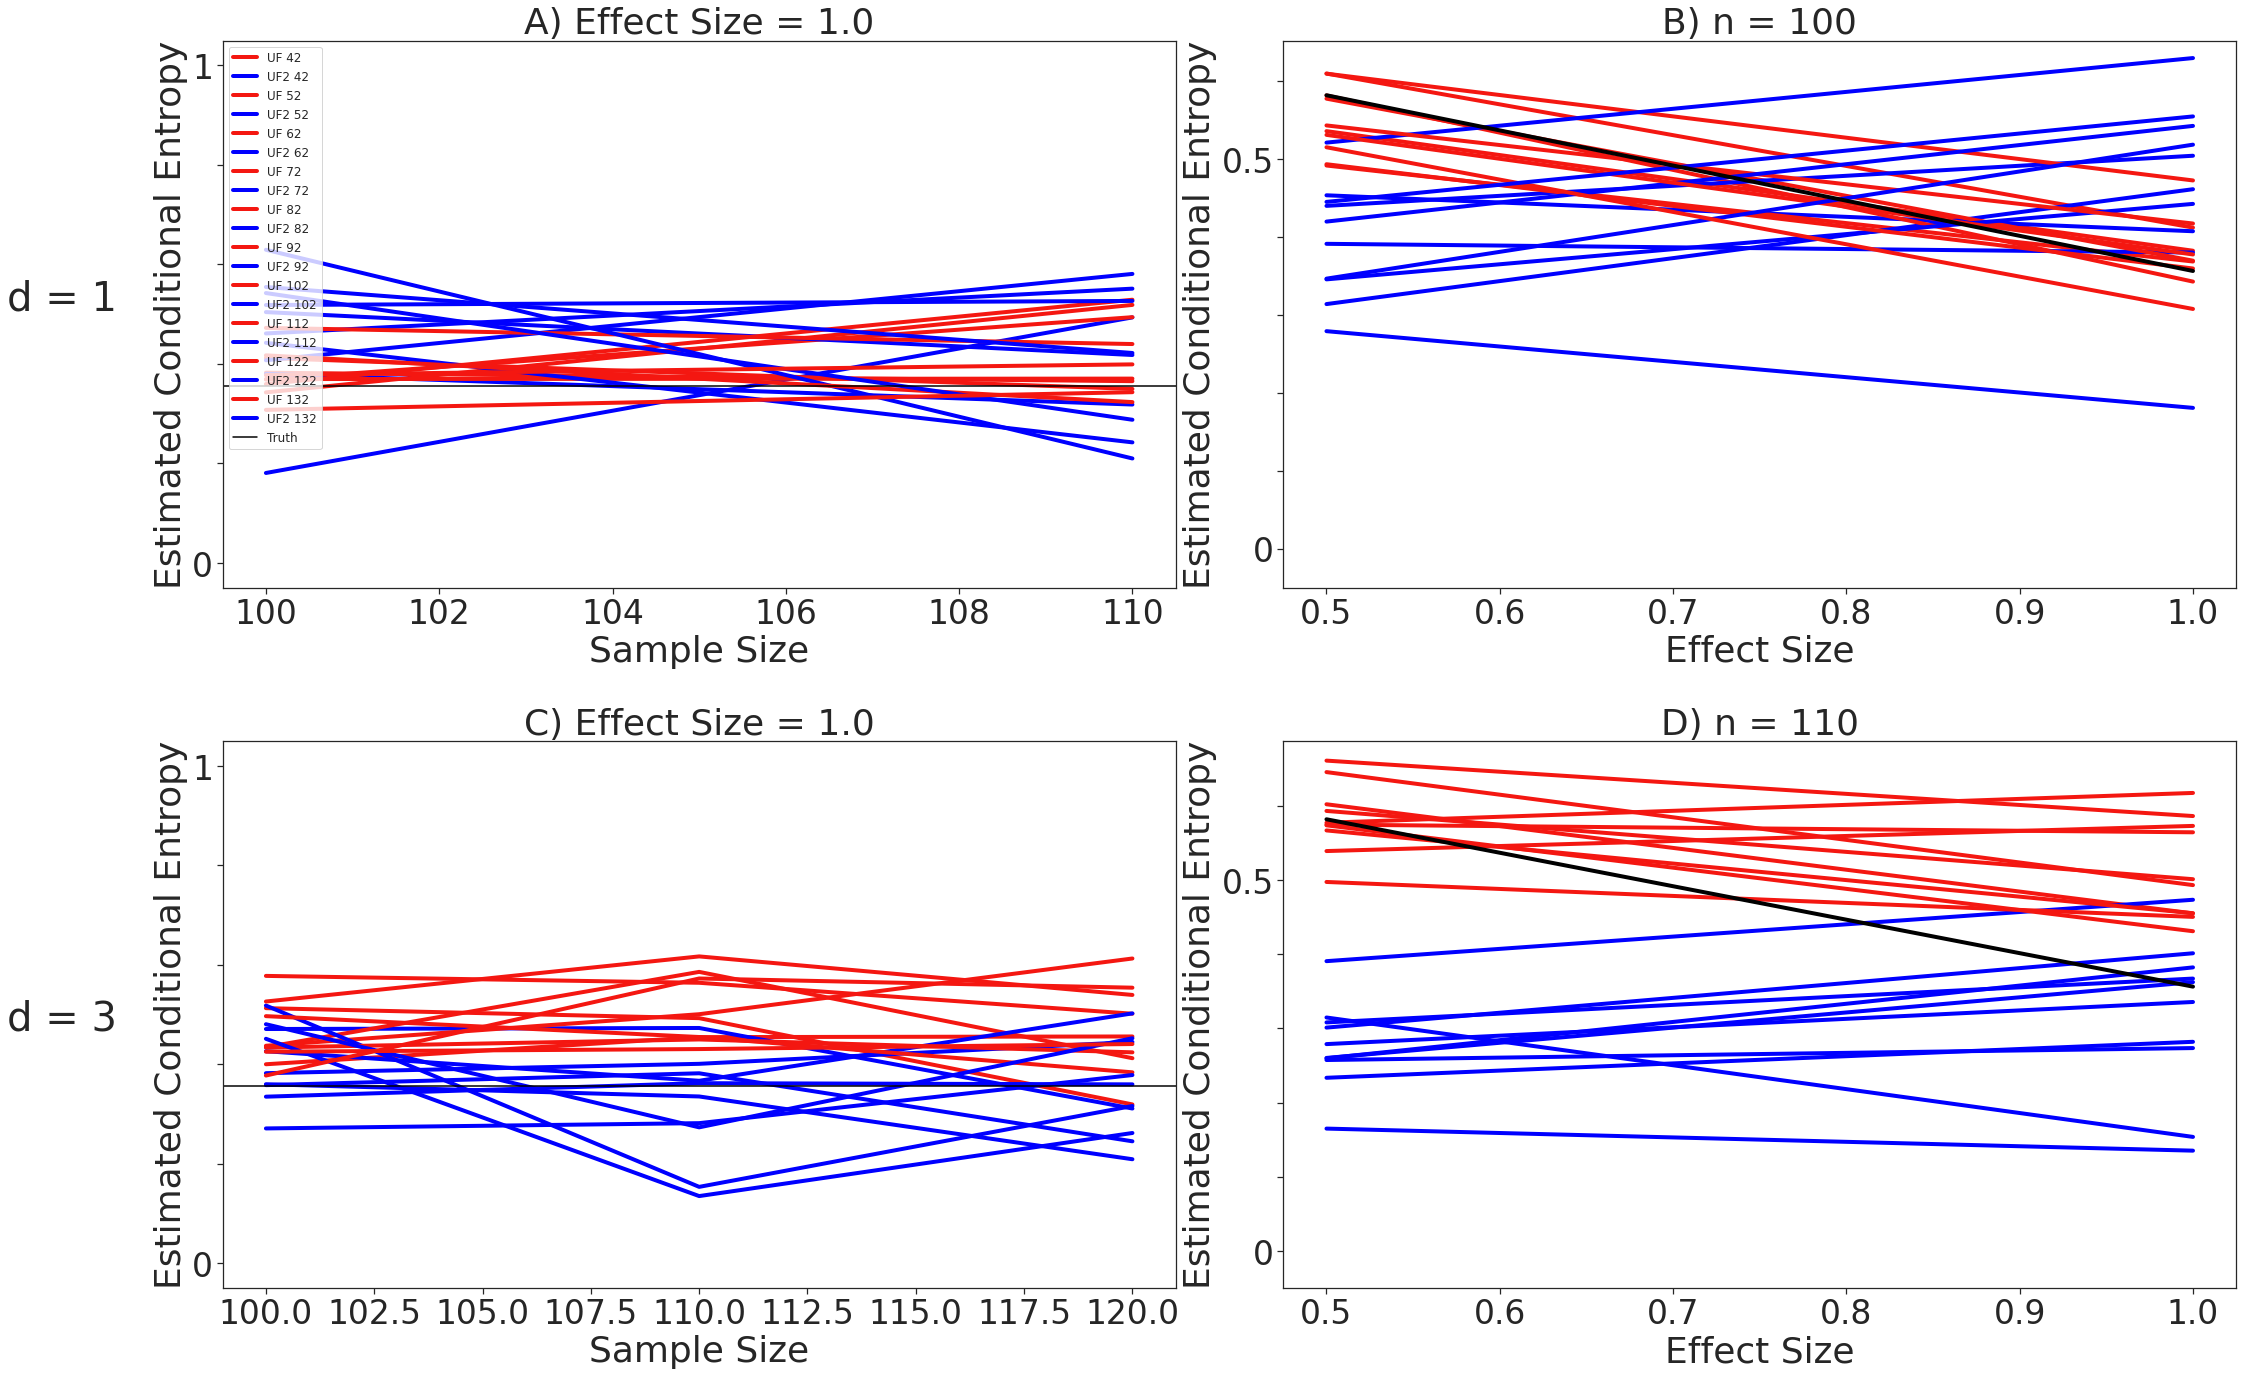

In [21]:
plot_fig2(num_plotted_trials, d1, d2, n1, n2, effect_size, algos)

In [29]:
def plot_posteriors():
    sns.set(font_scale = 3)
    sns.set_style("ticks")
    plt.rcParams["font.family"] = "sans-serif"
    plt.rcParams['figure.figsize'] = [30, 20]
    fig, axes = plt.subplots(1, 2)

    # print(len(posteriors1))
    # print(len(posteriors1[0]))
    # print(len(posteriors1[1]))
    # print(len(posteriors1[2]))

    # posteriors1_nd = np.ndarray(posteriors1)
    

    # posteriors1_rs = posteriors1.reshape(len(posteriors1_nd(0))*len(posteriors1_nd), 2)

    # print(posteriors1_rs[0])

    # print(posteriors1[0][0][:])
    # print(posteriors1[0][1][:])


    for i in range(int(len(posteriors1)/1)): #len(posteriors1)
        print(i)
        for j in range(len(posteriors1[i])):
            axes[0].scatter(posteriors1[i][j][0], posteriors1[i][j][1])

    for i in range(int(len(posteriors2)/1)): #len(posteriors1)
        print(i)
        for j in range(len(posteriors2[i])):
            axes[1].scatter(posteriors2[i][j][0], posteriors2[i][j][1])
    
    # axes[0].scatter(posteriors1[0], posteriors1[1])
    # axes[1].scatter(posteriors2[0], posteriors2[1])
    
    # axes[0,0].legend(loc = "upper left")
    
    # fig.text(-0.05, 0.27, 'd = %d' % d2, ha='left', va='center', fontsize = 40)
    # fig.text(-0.05, 0.77, 'd = %d' % d1, ha='left', va='center', fontsize = 40)
    
    plt.subplots_adjust(left=-1)
    axes[0].set_title('UF1')
    axes[0].set_xlabel('Feature 1 posterior')
    axes[0].set_ylabel('Feature 2 posterior')

    axes[1].set_title('UF2')
    axes[1].set_xlabel('Feature 1 posterior')
    axes[1].set_ylabel('Feature 2 posterior')

    plt.tight_layout()    
    plt.savefig("fig2_posteriors.pdf", bbox_inches = "tight")
    plt.show()

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124


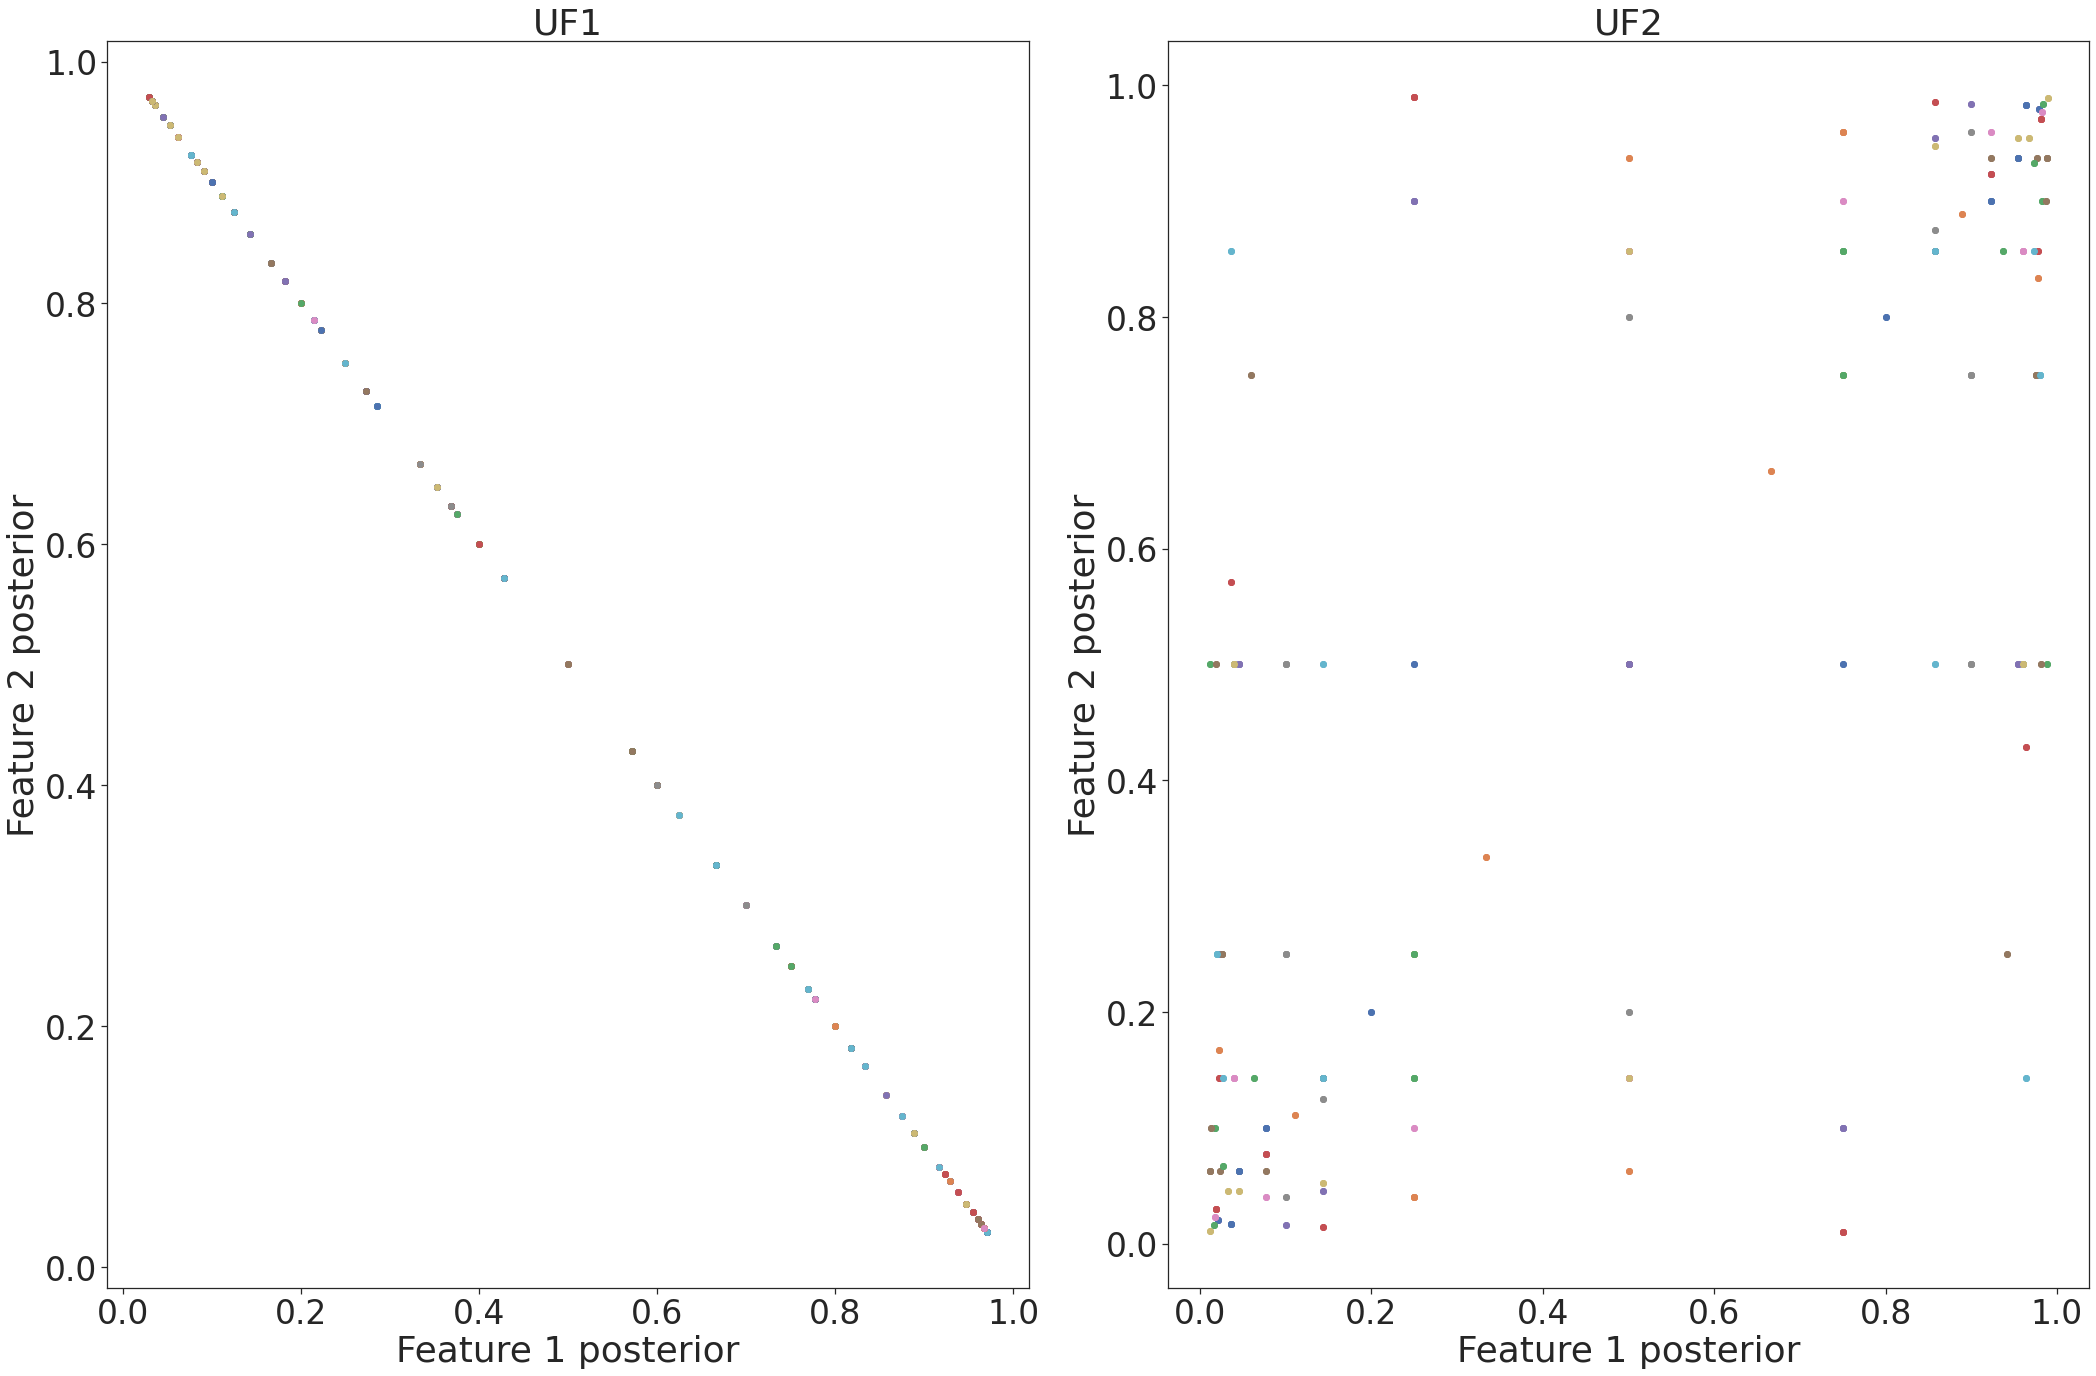

In [30]:
plot_posteriors()